In this notebook, we display the circuit we are using. We also investigate the mapping from logical circuit to physical circuit.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# GPU check
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg import (
    HeisenbergModel,
    HeisenbergModelGPU,
    get_graph,
    get_positions,
    # get_initial_layout,
    # get_prob0,
)
from setup import setup_backend
from helper_features import run_job, get_features
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Statevector, entropy, partial_trace
from qiskit.visualization import plot_circuit_layout
import pickle
import networkx as nx
from datetime import datetime, timezone
import json
import math

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# statevector simulator
backend_qpu, backend_sv_noiseless, backend_sv_noisy = setup_backend(
    # qpu_name="ibm_marrakesh", device="GPU", method="statevector"
    qpu_name="ibm_fez",
    device="GPU",
    method="statevector",
)

Using backend QPU: <IBMBackend('ibm_fez')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'sx', 'id', 'measure', 'cz', 'x']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset',

In [ ]:
# density matrix simulator
backend_qpu, backend_dm_noiseless, backend_dm_noisy = setup_backend(
    # qpu_name="ibm_marrakesh", device="GPU", method="density_matrix"
    qpu_name="ibm_fez",
    device="GPU",
    method="statevector",
)

# matrix product state simulator
backend_qpu, backend_mps_noiseless, backend_mps_noisy = setup_backend(
    # qpu_name="ibm_marrakesh", device="GPU", method="matrix_product_state"
    qpu_name="ibm_fez",
    device="GPU",
    method="statevector",
)

Using backend QPU: <IBMBackend('ibm_fez')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'sx', 'id', 'measure', 'cz', 'x']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset',

depth: 21
ops: OrderedDict([('cx', 34), ('rx', 12), ('rz', 12), ('rzx', 12), ('measure', 12), ('h', 2), ('barrier', 1)])


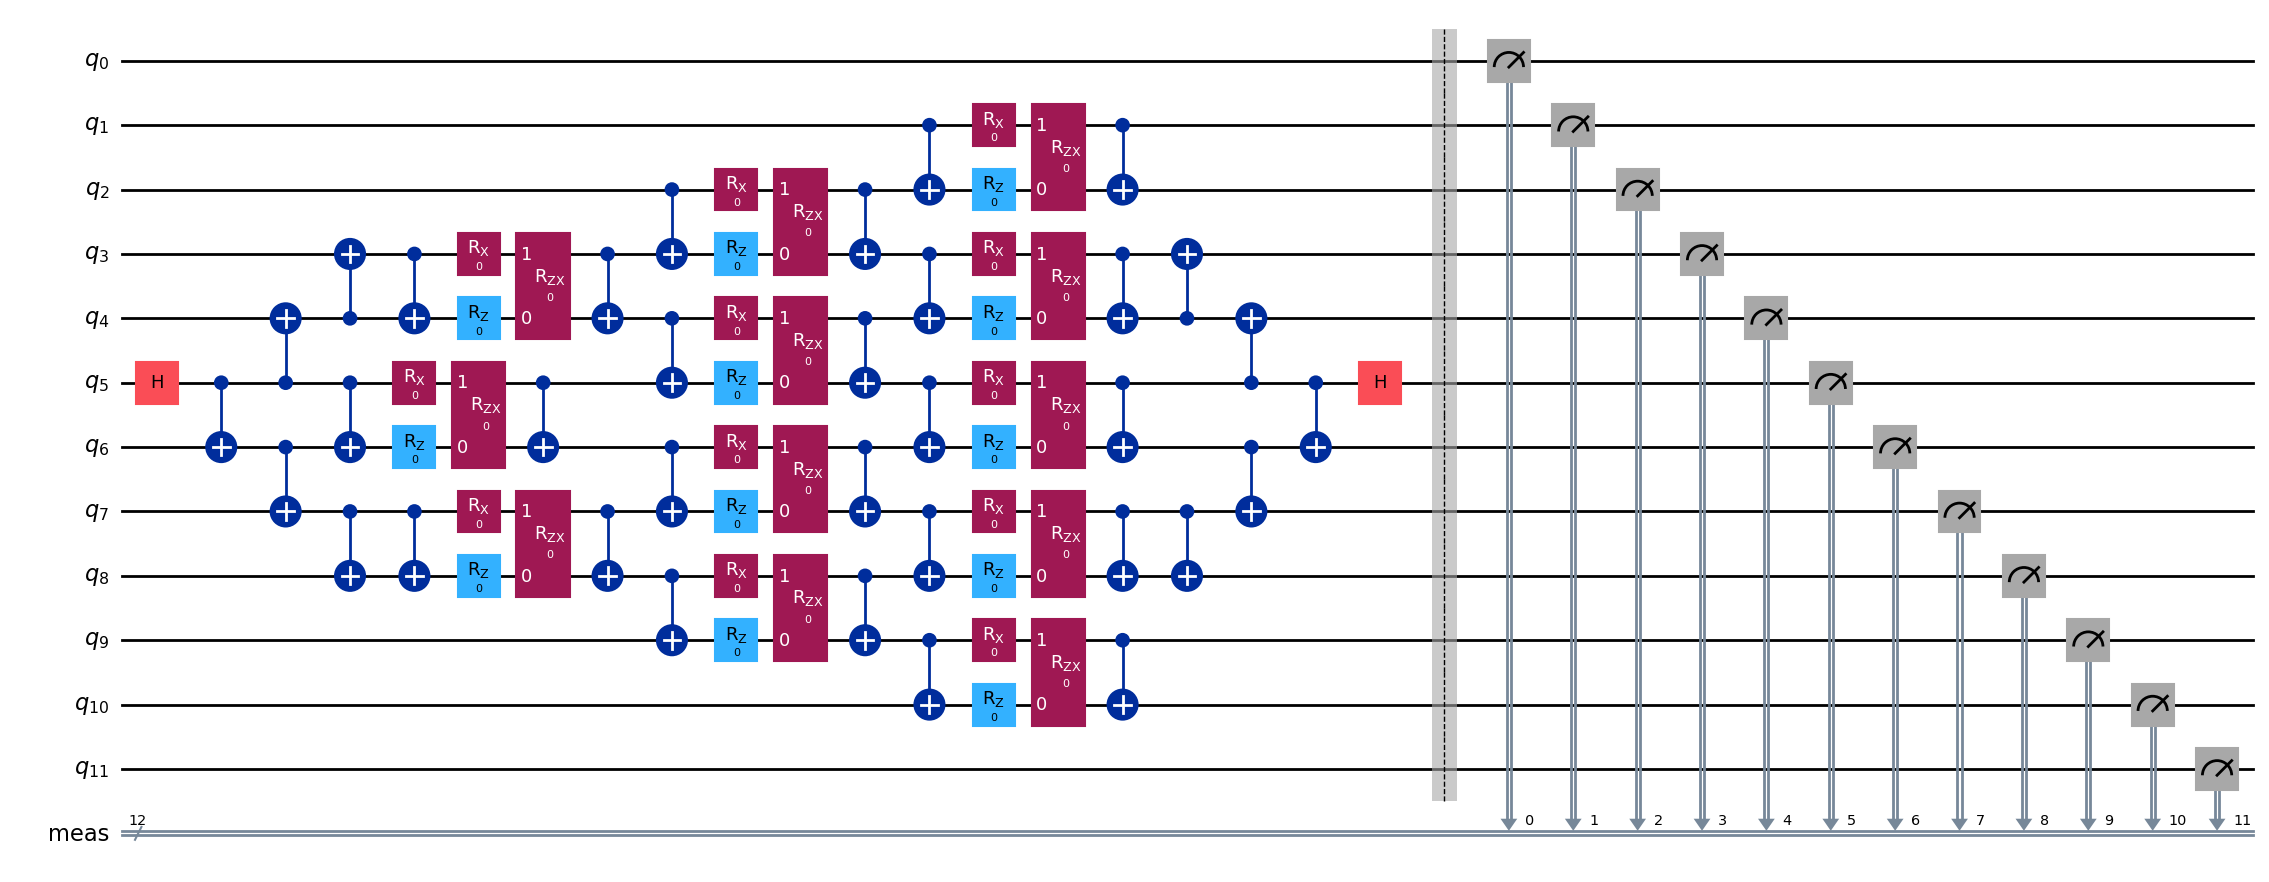

In [10]:
n_qubits = 12
t = 0
n_step = 1

# define the Heisenberg model
Js = [1.0] * (n_qubits - 1)
G = get_graph(n_qubits, Js)

heisenberg = HeisenbergModelGPU(n_qubits, G)

circuit = heisenberg.get_circuit(total_time=t, n_step=n_step, phase=0)
# circuit.remove_final_measurements()
print(f"depth: {circuit.depth()}")
print(f"ops: {circuit.count_ops()}")
circuit.draw(output="mpl", fold=-1)

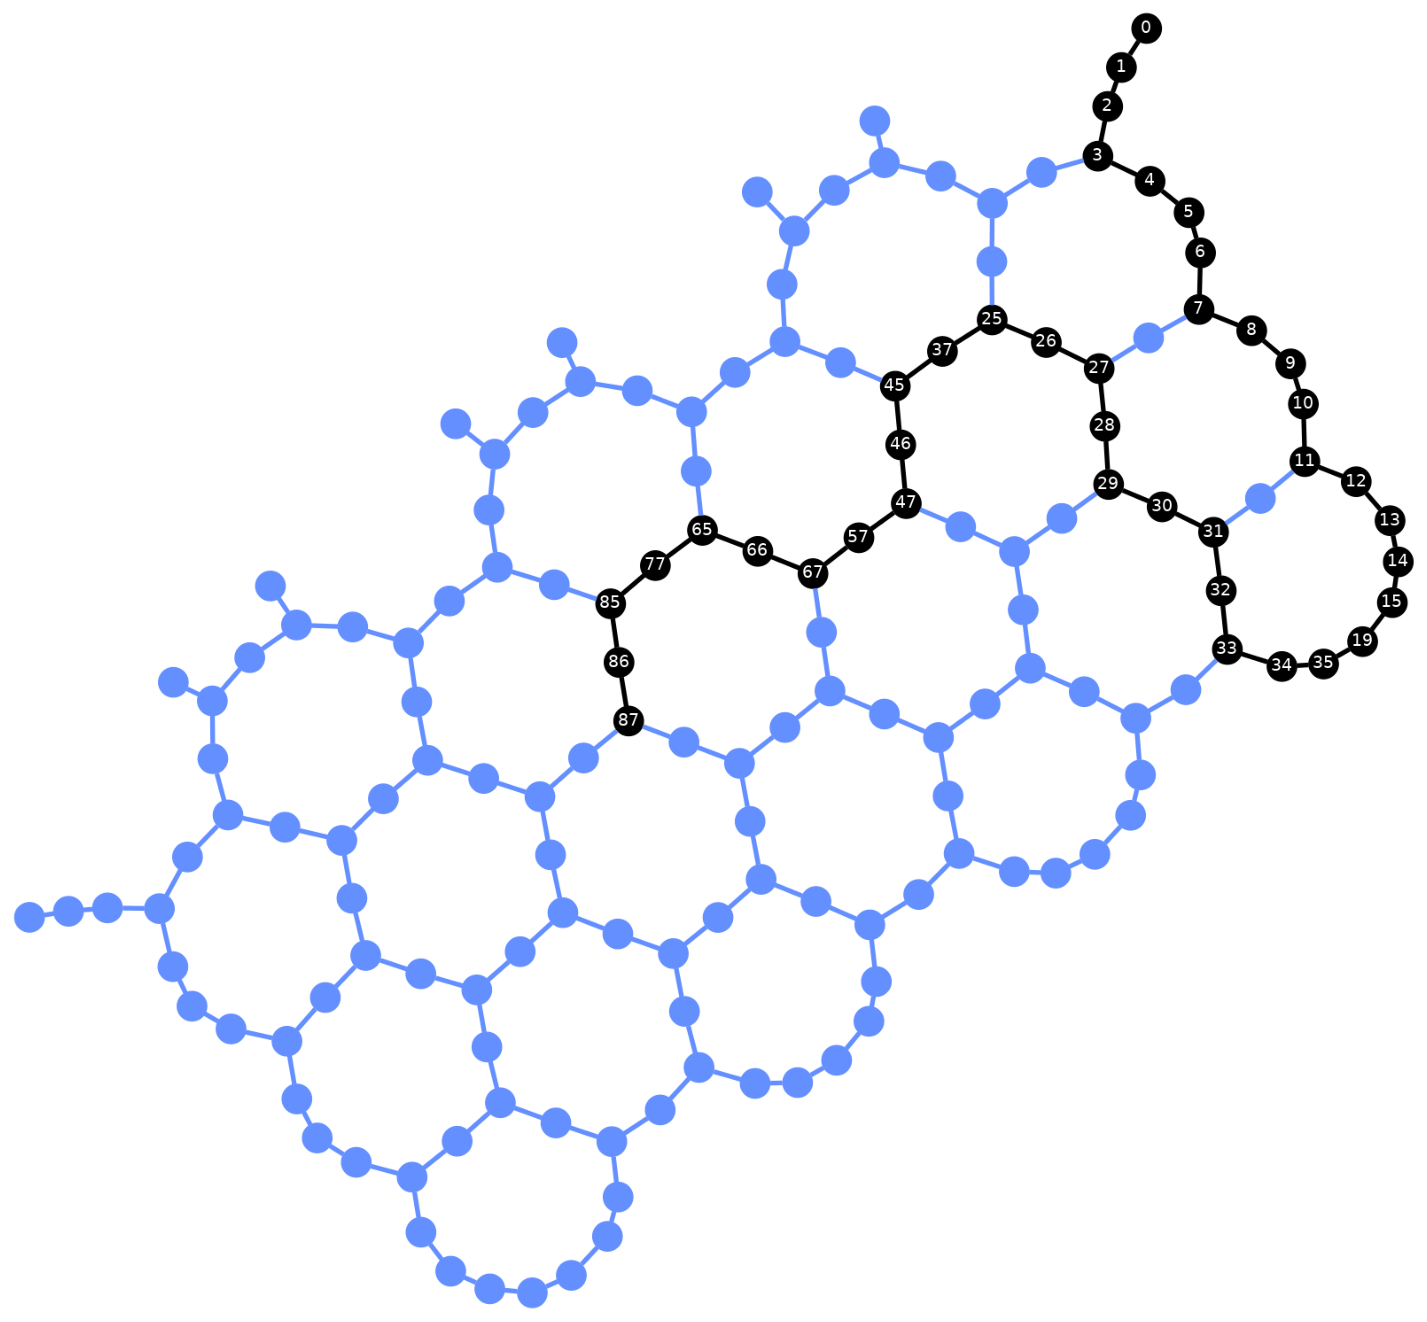

In [ ]:
initial_layout_52 = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    19,
    35,
    34,
    33,
    32,
    31,
    30,
    29,
    28,
    27,
    26,
    25,
    37,
    45,
    46,
    47,
    57,
    67,
    66,
    65,
    77,
    85,
    86,
    87,
    97,
    107,
    106,
    105,
    117,
    125,
    124,
    123,
    136,
    143,
    144,
    145,
]
if n_qubits <= 15:
    initial_layout = list(
        range(n_qubits)
    )  # Use physical qubits [0, 1, ..., n_qubits-1]
else:
    initial_layout = initial_layout_52[:n_qubits]

exec_circuit = transpile(circuit, backend_qpu, initial_layout=initial_layout)
plot_circuit_layout(exec_circuit, backend_qpu, view="physical")